In [70]:
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

def download_binance_klines(symbol, interval, date, is_spot=True):
    base_url = "https://data.binance.vision/data/spot/daily/klines/" if is_spot else "https://data.binance.vision/data/futures/um/daily/klines/"
    date_str = date.strftime('%Y-%m-%d')
    url = f"{base_url}{symbol}/{interval}/{symbol}-{interval}-{date_str}.zip"
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            with z.open(f"{symbol}-{interval}-{date_str}.csv") as f:
                data = pd.read_csv(f, header=None, skiprows=1, names=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
                data['open_time'] = pd.to_datetime(data['open_time'], unit='ms', errors='coerce')
                data.set_index('open_time', inplace=True)
                data = data[['open', 'high', 'low', 'close', 'volume']].astype(float)
                return data
    else:
        return pd.DataFrame()

def download_all_klines(symbol, interval, dates, is_spot=True):
    all_data = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(download_binance_klines, symbol, interval, date, is_spot): date for date in dates}
        for future in as_completed(futures):
            data = future.result()
            if not data.empty:
                all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# 获取期货数据
start_date = datetime.strptime('2023-03-31', '%Y-%m-%d')
end_date = datetime.strptime('2024-03-31', '%Y-%m-%d')
dates = pd.date_range(start=start_date, end=end_date, freq='D')

futures_klines = download_all_klines('BTCUSDT', '1m', dates, is_spot=False)

# 获取现货数据
spot_klines = download_all_klines('BTCUSDT', '1m', dates, is_spot=True)


In [71]:
futures_klines 


,open,high,low,close,volume
0,28454.8,28475.6,28454.8,28474.8,356.923
1,28474.7,28477.3,28457.3,28457.4,202.951
2,28457.3,28473.6,28447.3,28453.9,404.994
3,28454.0,28454.0,28442.1,28444.4,365.287
4,28444.4,28447.0,28438.0,28442.5,228.816
...,...,...,...,...,...
528475,71328.5,71359.8,71318.5,71359.7,152.879
528476,71359.7,71443.0,71359.7,71431.0,249.528
528477,71430.9,71495.5,71399.2,71463.1,421.148
528478,71463.1,71463.1,71410.0,71414.9,128.791


In [72]:
spot_klines

,open,high,low,close,volume
0,28166.58,28166.58,28153.80,28153.80,19.09088
1,28153.81,28160.33,28153.80,28155.90,25.45438
2,28155.90,28159.62,28151.69,28151.70,35.25667
3,28151.70,28155.92,28151.37,28155.91,12.10273
4,28155.91,28155.92,28152.87,28152.88,16.17513
...,...,...,...,...,...
528108,69674.74,69674.74,69655.67,69655.67,10.09238
528109,69655.68,69655.68,69618.90,69618.90,11.72869
528110,69618.91,69618.91,69597.02,69614.99,16.50174
528111,69614.99,69614.99,69614.98,69614.99,3.11693


In [73]:
basis = futures_klines['close'] - spot_klines['close']
premium_rate = basis / spot_klines['close']


In [74]:
import matplotlib.pyplot as plt
def plot(x, title):
    plt.figure(figsize=(14, 7))
    
    plt.plot(x.values, label='values', color='blue')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




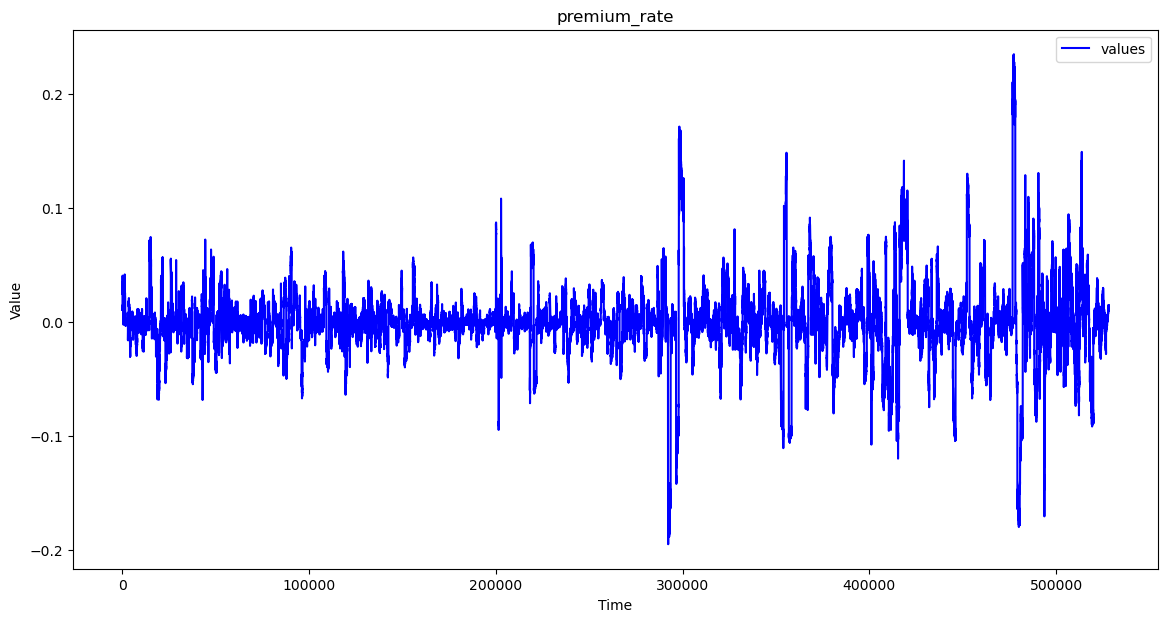

In [75]:
plot(premium_rate, 'premium_rate')

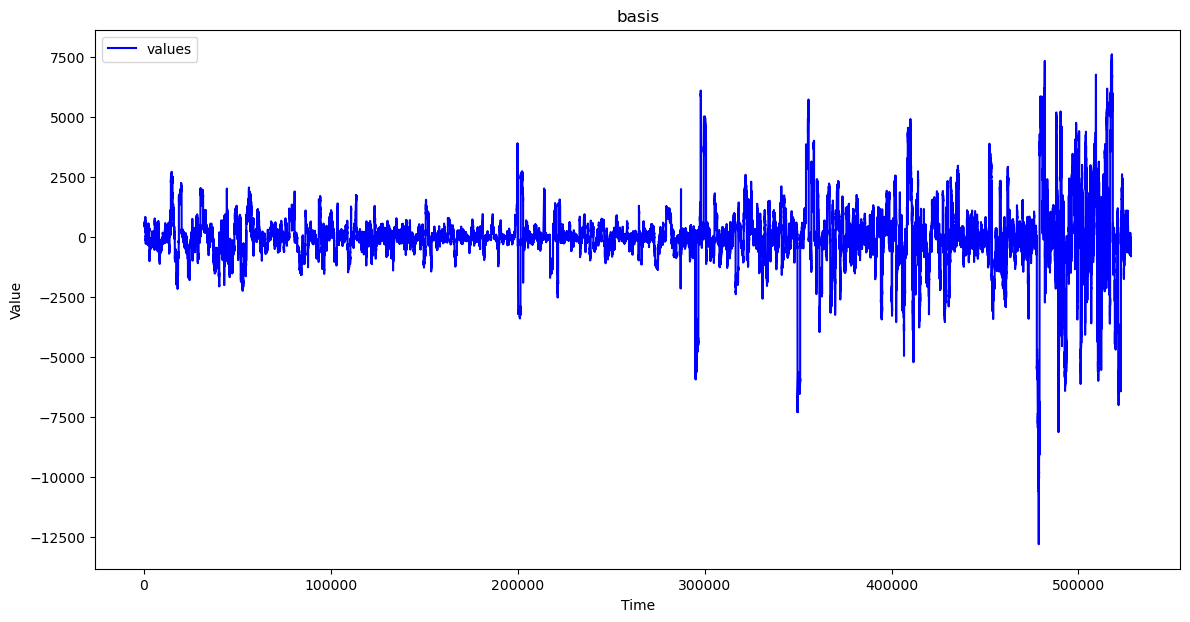

In [68]:
plot(basis,'basis')


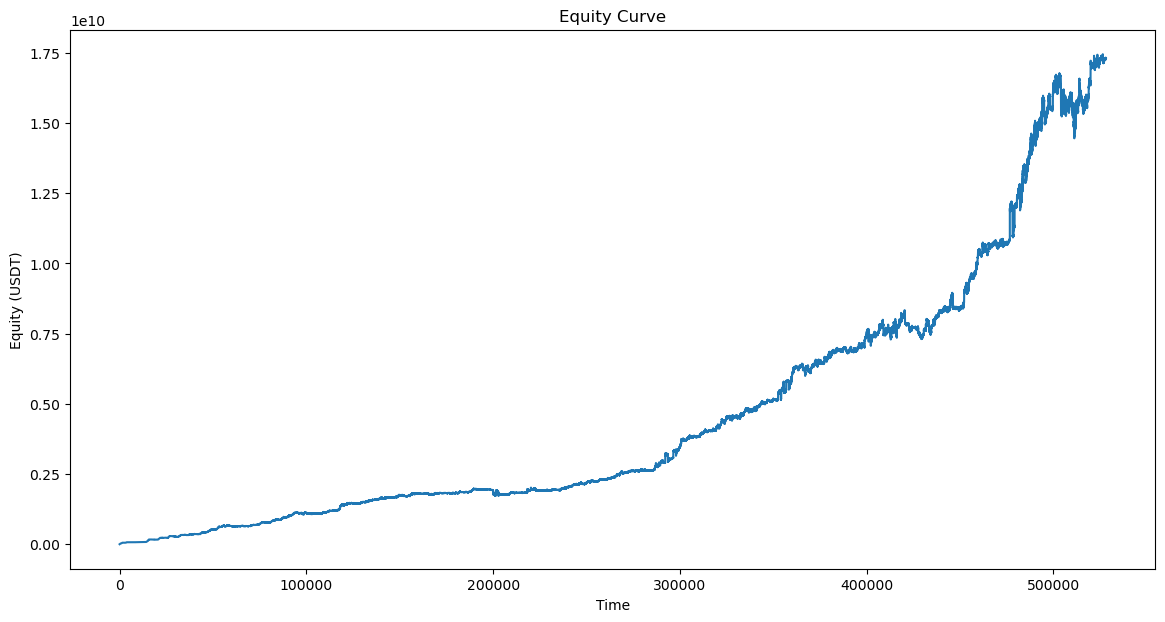

Sharpe Ratio: 0.31
Max Drawdown: 2310958.65%
Calmar Ratio: 0.00


In [77]:
import numpy as np
import matplotlib.pyplot as plt

# 回测参数
initial_capital = 100000  # 初始资金
position_size = 1  # 每次交易的BTC数量
fee_spot = 0.001  # 现货手续费
fee_futures = 0.0005  # 期货手续费
slippage = 0.0005  # 市场冲击成本

# 回测框架
class Backtest:
    def __init__(self, spot_prices, futures_prices, premium_rate, initial_capital):
        self.spot_prices = spot_prices
        self.futures_prices = futures_prices
        self.premium_rate = premium_rate
        self.initial_capital = initial_capital
        self.cash = initial_capital
        self.position_spot = 0
        self.position_futures = 0
        self.equity_curve = []

    def execute_trade(self, trade_type, price, size, is_spot=True):
        if is_spot:
            fee = fee_spot
        else:
            fee = fee_futures
        
        if trade_type == 'buy':
            cost = size * price * (1 + fee + slippage)
            if self.cash >= cost:
                self.cash -= cost
                if is_spot:
                    self.position_spot += size
                else:
                    self.position_futures += size
        elif trade_type == 'sell':
            revenue = size * price * (1 - fee - slippage)
            if is_spot:
                self.position_spot -= size
            else:
                self.position_futures -= size
            self.cash += revenue

    def run_backtest(self, threshold=0.01):
        for i in range(len(self.spot_prices)):
            if self.premium_rate[i] > threshold:
                self.execute_trade('buy', self.spot_prices[i], position_size, is_spot=True)
                self.execute_trade('sell', self.futures_prices[i], position_size, is_spot=False)
            self.equity_curve.append(self.cash + self.position_spot * self.spot_prices[i] - self.position_futures * self.futures_prices[i])

    def plot_equity_curve(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.equity_curve)
        plt.title('Equity Curve')
        plt.xlabel('Time')
        plt.ylabel('Equity (USDT)')
        plt.show()

    def get_metrics(self):
        returns = pd.Series(self.equity_curve).pct_change().dropna()
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
        max_drawdown = np.max(np.maximum.accumulate(self.equity_curve) - self.equity_curve)
        max_drawdown_percent = max_drawdown / self.initial_capital
        calmar_ratio = np.mean(returns) * 252 / max_drawdown_percent
        return sharpe_ratio, max_drawdown_percent, calmar_ratio

# 运行回测
backtest = Backtest(spot_klines['close'], futures_klines['close'], premium_rate, initial_capital)
backtest.run_backtest()
backtest.plot_equity_curve()

# 计算回测结果
sharpe_ratio, max_drawdown_percent, calmar_ratio = backtest.get_metrics()

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max Drawdown: {max_drawdown_percent:.2%}')
print(f'Calmar Ratio: {calmar_ratio:.2f}')
